In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import json
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Residuals TS

In [2]:
#Load residuals and set index as datetime
residuals_raw = pd.read_csv('Residuals_from_random_forest.csv', encoding='latin1', index_col='date_hour')
residuals_raw.index = residuals_raw.index.to_datetime()
residuals = residuals_raw.asfreq('H')

In [3]:
residuals['residuals-1'] = residuals.diff()

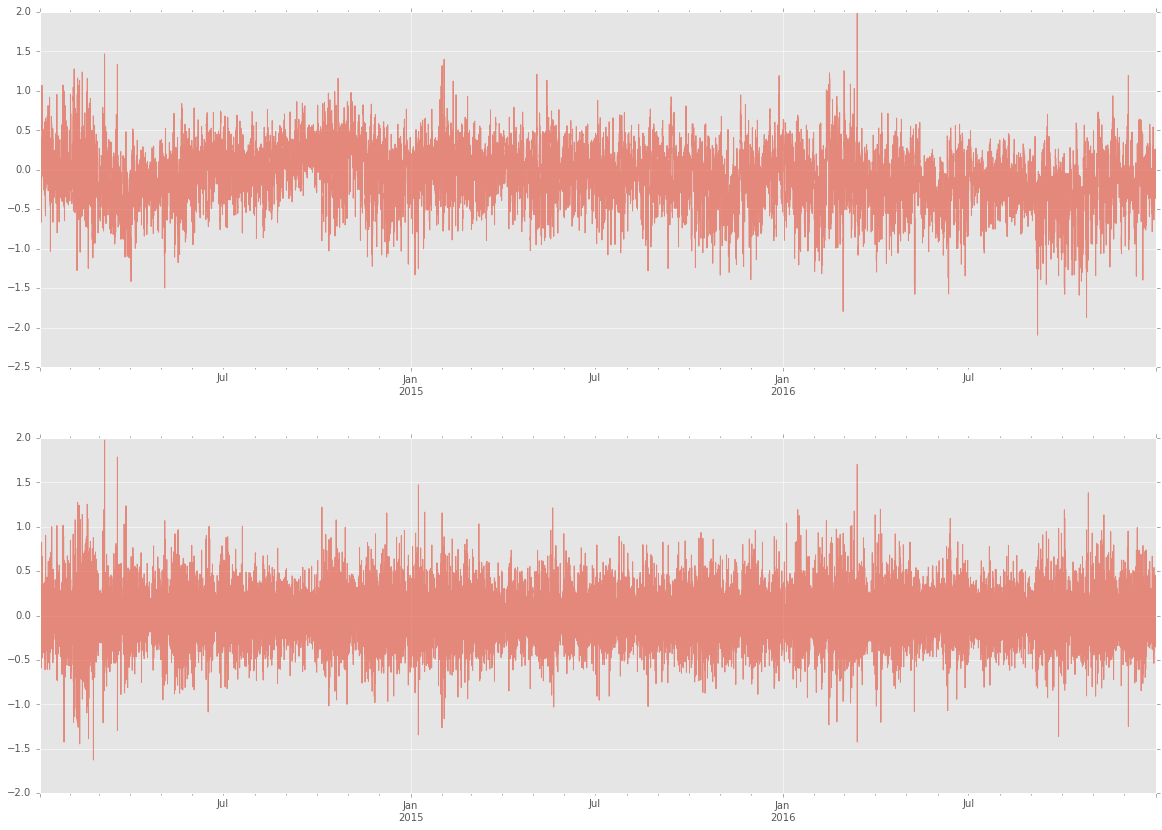

In [4]:
#Plot residual TS
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,14))
residuals['residuals'].iloc[1:].plot(ax=ax0, alpha=0.6)
residuals['residuals-1'].plot(ax=ax1, alpha=0.6);

### Dick-Fuller test on stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [7]:
perform_stationarity_test(residuals['residuals'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.443782e+01
p-value                       7.444821e-27
#Lags used                    4.900000e+01
Number of observation used    2.623000e+04
Critical value (1%)          -3.430599e+00
Critical value (10%)         -2.566829e+00
Critical value (5%)          -2.861650e+00
dtype: float64


In [8]:
perform_stationarity_test(residuals['residuals-1'].dropna())

Results of the Dickey-Fuller Test:
Test Statistic                  -35.549407
p-value                           0.000000
#Lags used                       48.000000
Number of observation used    26230.000000
Critical value (1%)              -3.430599
Critical value (10%)             -2.566829
Critical value (5%)              -2.861650
dtype: float64


### ACF and PACF

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [10]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

In [ ]:
#ACF and PACF suggest an ARMA model with p = 2 or 3 and q = 0
computer_acf_pacf(residuals['residuals'], 720, 720)

In [ ]:
computer_acf_pacf(residuals['residuals-1'].dropna(), 720, 720)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,10))
fig = plot_acf(residuals['residuals'], lags=100, ax=ax0)
fig = plot_pacf(residuals['residuals'], lags=100, ax=ax1)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,10))
fig = plot_acf(residuals['residuals-1'].dropna(), lags=100, ax=ax0)
fig = plot_pacf(residuals['residuals-1'].dropna(), lags=100, ax=ax1)

### ARIMA model, p=3; q=0

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [12]:
ar = np.zeros(26*3)

In [13]:
ar

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [14]:
for i in [1,2,3]:
    ar[23*i+i-1:23*i+i-1+2] = 1

In [15]:
ar = tuple(ar)

In [16]:
model = SARIMAX(endog=residuals['residuals'].values, order=(ar,0,0))#, seasonal_order=(3,0,0,24))

In [ ]:
%%time
results = model.fit(maxiter=500, disp=-1)

In [ ]:
print(results.summary())

In [ ]:
def compute_SARIMAX_model(timeseries, p, d, q):
    model = SARIMAX(timeseries, order=(p,d,q), trend='n')
    results = model.fit(disp=True, maxiter=500, trend='nc')
    return results

In [ ]:
def check_cv_fold(timeseries, train_index, test_index, p,d,q):
    model = compute_ARIMA_model(timeseries.iloc[train_index], p, d, q)
    y_pred = np.reshape(model.forecast(steps=24)[0], (24,))
    y_true = timeseries.iloc[test_index].values[:24]
    error = mean_squared_error(y_true, y_pred)
    train_residuals = np.mean(model.resid**2)
    print('train length: %d, train MSE %.4f, test MSE %.4f' %(len(train_index), train_residuals, error))
    return train_residuals, error

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
train_error = list()
test_error = list()
for train_index, test_index in tscv.split(residuals['residuals'].values):
    tr_error, ts_error =check_cv_fold(residuals, train_index, test_index, 3,0,0)
    train_error.append(tr_error)
    test_error.append(ts_error)
print('CV Train MSE: %.4f, Test MSE: %.4f' %(np.mean(train_error), np.mean(test_error)))

In [ ]:
fitted_model = compute_ARIMA_model(residuals, 3, 0, 0)

In [ ]:
print(fitted_model.summary2())

In [ ]:
#Export armaparams into a json
arima_parameters ={
    'ar':fitted_model.arparams.tolist(),
    'std':fitted_model.resid.std()
}

with open('arima_parameters.json', 'w') as f:
     json.dump(arima_parameters, f)